# EDA for Stock News and Price Data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from transformers import pipeline # Added for BERT/FinBERT
import torch # Added for transformers

# Download VADER lexicon if not already present
try:
    sid = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vader_lexicon')
    sid = SentimentIntensityAnalyzer()

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

/home/akshat/miniconda3/envs/cvproj/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Data

In [17]:
df = pd.read_csv('/home/akshat/inlp/final_model_input_1000.csv')
print(f"Dataset shape: {df.shape}")
# For faster experimentation with transformers, consider using a sample:
# df_sample = df.sample(n=1000, random_state=42).copy()
# df = df_sample # Uncomment to use the sample
df.head()

Dataset shape: (135904, 11)


,news_title,Ticker,merge_date_utc,date,Open,High,Low,Close,Volume,Next_Day_Close,Price_Up_Binary
0,Stocks That Hit 52-Week Highs On Friday,A,2020-06-05,2020-06-05 10:30:00-04:00,89.070968,89.950757,87.098702,87.379074,2844700.0,87.292076,0.0
1,Stocks That Hit 52-Week Highs On Wednesday,A,2020-06-03,2020-06-03 10:45:00-04:00,87.640119,88.113847,87.263069,87.485428,1382500.0,88.113853,1.0
2,71 Biggest Movers From Friday,A,2020-05-26,2020-05-26 04:30:00-04:00,83.366903,83.908307,82.796489,83.270218,3173400.0,83.318558,1.0
3,46 Stocks Moving In Friday's Mid-Day Session,A,2020-05-22,2020-05-22 12:45:00-04:00,82.177727,84.759072,81.404286,82.158394,5063100.0,83.270218,1.0
4,B of A Securities Maintains Neutral on Agilent...,A,2020-05-22,2020-05-22 11:38:00-04:00,82.177727,84.759072,81.404286,82.158394,5063100.0,83.270218,1.0


## 2. Basic Data Exploration

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135904 entries, 0 to 135903
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   news_title       135904 non-null  object 
 1   Ticker           135904 non-null  object 
 2   merge_date_utc   135904 non-null  object 
 3   date             135904 non-null  object 
 4   Open             135904 non-null  float64
 5   High             135904 non-null  float64
 6   Low              135904 non-null  float64
 7   Close            135904 non-null  float64
 8   Volume           135904 non-null  float64
 9   Next_Day_Close   135904 non-null  float64
 10  Price_Up_Binary  135904 non-null  float64
dtypes: float64(7), object(4)
memory usage: 11.4+ MB


In [19]:
df.describe(include='all')

,news_title,Ticker,merge_date_utc,date,Open,High,Low,Close,Volume,Next_Day_Close,Price_Up_Binary
count,135904,135904,135904,135904,1.359040e+05,1.359040e+05,1.359040e+05,1.359040e+05,1.359040e+05,1.359040e+05,135904.000000
unique,105048,552,2733,106459,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Benzinga's Top Upgrades,BABA,2020-03-12,2020-03-12 12:10:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,552,2742,401,244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.585987e+02,1.626022e+02,1.540517e+02,1.576891e+02,7.375474e+06,1.581032e+02,0.505371
std,NaN,NaN,NaN,NaN,7.432465e+03,7.570109e+03,7.206627e+03,7.337733e+03,2.161779e+07,7.437949e+03,0.499973
min,NaN,NaN,NaN,NaN,4.000000e-03,4.000000e-03,4.000000e-03,4.000000e-03,0.000000e+00,6.500000e-03,0.000000
25%,NaN,NaN,NaN,NaN,1.575953e+01,1.615422e+01,1.541732e+01,1.575560e+01,4.829000e+05,1.583826e+01,0.000000
50%,NaN,NaN,NaN,NaN,3.200000e+01,3.258000e+01,3.130000e+01,3.199047e+01,1.828000e+06,3.199410e+01,1.000000
75%,NaN,NaN,NaN,NaN,6.457681e+01,6.574637e+01,6.353510e+01,6.473400e+01,5.604600e+06,6.464220e+01,1.000000


In [20]:
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


news_title         0
Ticker             0
merge_date_utc     0
date               0
Open               0
High               0
Low                0
Close              0
Volume             0
Next_Day_Close     0
Price_Up_Binary    0
dtype: int64

### Target Variable Distribution (`Price_Up_Binary`)

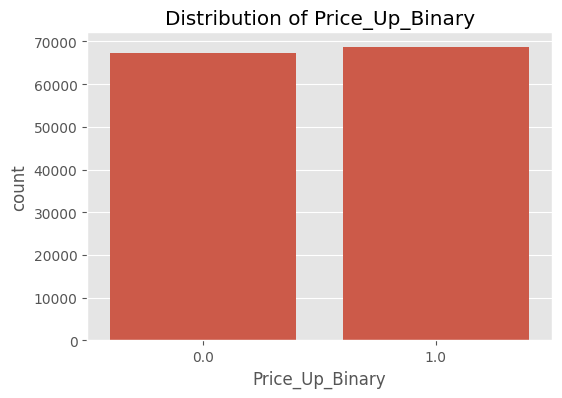

Price_Up_Binary
1.0    0.505371
0.0    0.494629
Name: proportion, dtype: float64


In [21]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Price_Up_Binary', data=df)
plt.title('Distribution of Price_Up_Binary')
plt.show()
print(df['Price_Up_Binary'].value_counts(normalize=True))

## 3. News Sentiment Analysis (VADER)

In [22]:
df['vader_sentiment_score'] = df['news_title'].apply(lambda title: sid.polarity_scores(str(title))['compound'])
df[['news_title', 'vader_sentiment_score']].head()

,news_title,vader_sentiment_score
0,Stocks That Hit 52-Week Highs On Friday,0.000
1,Stocks That Hit 52-Week Highs On Wednesday,0.000
2,71 Biggest Movers From Friday,0.000
3,46 Stocks Moving In Friday's Mid-Day Session,0.000
4,B of A Securities Maintains Neutral on Agilent...,0.296


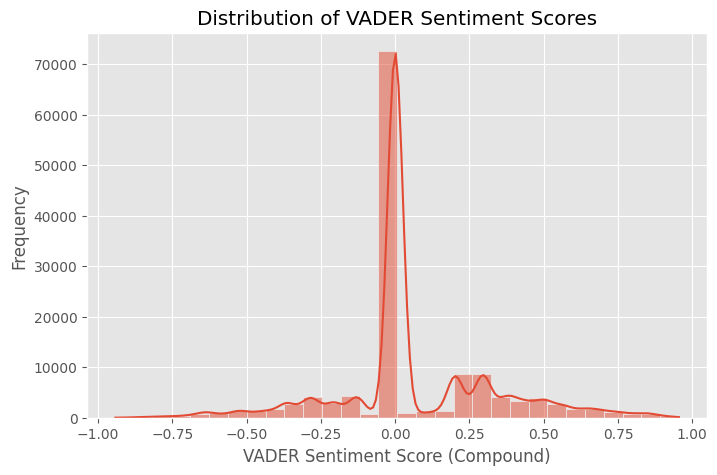

count    135904.000000
mean          0.063703
std           0.271028
min          -0.942300
25%           0.000000
50%           0.000000
75%           0.202300
max           0.955200
Name: vader_sentiment_score, dtype: float64

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(df['vader_sentiment_score'], bins=30, kde=True)
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('VADER Sentiment Score (Compound)')
plt.ylabel('Frequency')
plt.show()

df['vader_sentiment_score'].describe()

## 3.1 Advanced Sentiment Analysis (BERT & FinBERT)

We will now use transformer-based models for more sophisticated sentiment analysis.
1. **DistilBERT (fine-tuned on SST-2)**: A general-purpose sentiment analysis model.
2. **FinBERT**: A BERT model fine-tuned on financial domain text.

*Note: Running these models on the full dataset can be time-consuming. For quicker experimentation, consider using a smaller sample of the data (as commented out in the data loading cell).*

In [24]:
# Initialize DistilBERT sentiment pipeline
try:
    distilbert_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=0 if torch.cuda.is_available() else -1)
except Exception as e:
    print(f"Error initializing DistilBERT pipeline: {e}")
    distilbert_pipeline = None

def get_distilbert_sentiment(text, pipeline_model):
    if pipeline_model is None or not isinstance(text, str) or not text.strip():
        return 0.0
    try:
        # Truncate text to avoid exceeding model's max token limit
        max_length = 512 # Common max length for BERT models
        truncated_text = text[:max_length]
        result = pipeline_model(truncated_text)[0]
        score = result['score']
        if result['label'] == 'NEGATIVE':
            score = -score
        return score
    except Exception as e:
        print(f"Error processing text with DistilBERT: '{text}'. Error: {e}")
        return 0.0 # Neutral on error

if distilbert_pipeline:
    print("Calculating DistilBERT sentiment scores...")
    df['distilbert_sentiment_score'] = df['news_title'].apply(lambda x: get_distilbert_sentiment(x, distilbert_pipeline))
    print(df[['news_title', 'distilbert_sentiment_score']].head())
    df['distilbert_sentiment_score'].describe()
else:
    print("DistilBERT pipeline not available. Skipping DistilBERT sentiment analysis.")
    df['distilbert_sentiment_score'] = 0.0

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cuda:0
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Calculating DistilBERT sentiment scores...
                                          news_title  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

   distilbert_sentiment_score  
0                   -0.772919  
1                   -0.904384  
2                    0.999182  
3                   -0.896141  
4                   -0.972854  
                                          news_title  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

   distilbert_sentiment_score  
0                   -0.772919  
1                   -0.9043

In [25]:
# Initialize FinBERT sentiment pipeline
try:
    finbert_pipeline = pipeline("text-classification", model="ProsusAI/finbert", device=0 if torch.cuda.is_available() else -1)
except Exception as e:
    print(f"Error initializing FinBERT pipeline: {e}")
    finbert_pipeline = None

def get_finbert_sentiment(text, pipeline_model):
    if pipeline_model is None or not isinstance(text, str) or not text.strip():
        return 0.0
    try:
        max_length = 512
        truncated_text = text[:max_length]
        results = pipeline_model(truncated_text)
        scores = {r['label']: r['score'] for r in results}
        # Calculate a compound-like score: positive - negative
        compound_score = scores.get('positive', 0.0) - scores.get('negative', 0.0)
        return compound_score
    except Exception as e:
        print(f"Error processing text with FinBERT: '{text}'. Error: {e}")
        return 0.0 # Neutral on error

if finbert_pipeline:
    print("Calculating FinBERT sentiment scores...")
    df['finbert_sentiment_score'] = df['news_title'].apply(lambda x: get_finbert_sentiment(x, finbert_pipeline))
    print(df[['news_title', 'finbert_sentiment_score']].head())
    df['finbert_sentiment_score'].describe()
else:
    print("FinBERT pipeline not available. Skipping FinBERT sentiment analysis.")
    df['finbert_sentiment_score'] = 0.0

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cuda:0
Device set to use cuda:0


Calculating FinBERT sentiment scores...
                                          news_title  finbert_sentiment_score
0            Stocks That Hit 52-Week Highs On Friday                 0.000000
1         Stocks That Hit 52-Week Highs On Wednesday                 0.000000
2                      71 Biggest Movers From Friday                 0.000000
3       46 Stocks Moving In Friday's Mid-Day Session                 0.000000
4  B of A Securities Maintains Neutral on Agilent...                 0.662541
                                          news_title  finbert_sentiment_score
0            Stocks That Hit 52-Week Highs On Friday                 0.000000
1         Stocks That Hit 52-Week Highs On Wednesday                 0.000000
2                      71 Biggest Movers From Friday                 0.000000
3       46 Stocks Moving In Friday's Mid-Day Session                 0.000000
4  B of A Securities Maintains Neutral on Agilent...                 0.662541


### 3.2 Comparison of Sentiment Scores

In [26]:
print("DataFrame with all sentiment scores:")
df[['news_title', 'vader_sentiment_score', 'distilbert_sentiment_score', 'finbert_sentiment_score']].head()

DataFrame with all sentiment scores:


,news_title,vader_sentiment_score,distilbert_sentiment_score,finbert_sentiment_score
0,Stocks That Hit 52-Week Highs On Friday,0.000,-0.772919,0.000000
1,Stocks That Hit 52-Week Highs On Wednesday,0.000,-0.904384,0.000000
2,71 Biggest Movers From Friday,0.000,0.999182,0.000000
3,46 Stocks Moving In Friday's Mid-Day Session,0.000,-0.896141,0.000000
4,B of A Securities Maintains Neutral on Agilent...,0.296,-0.972854,0.662541


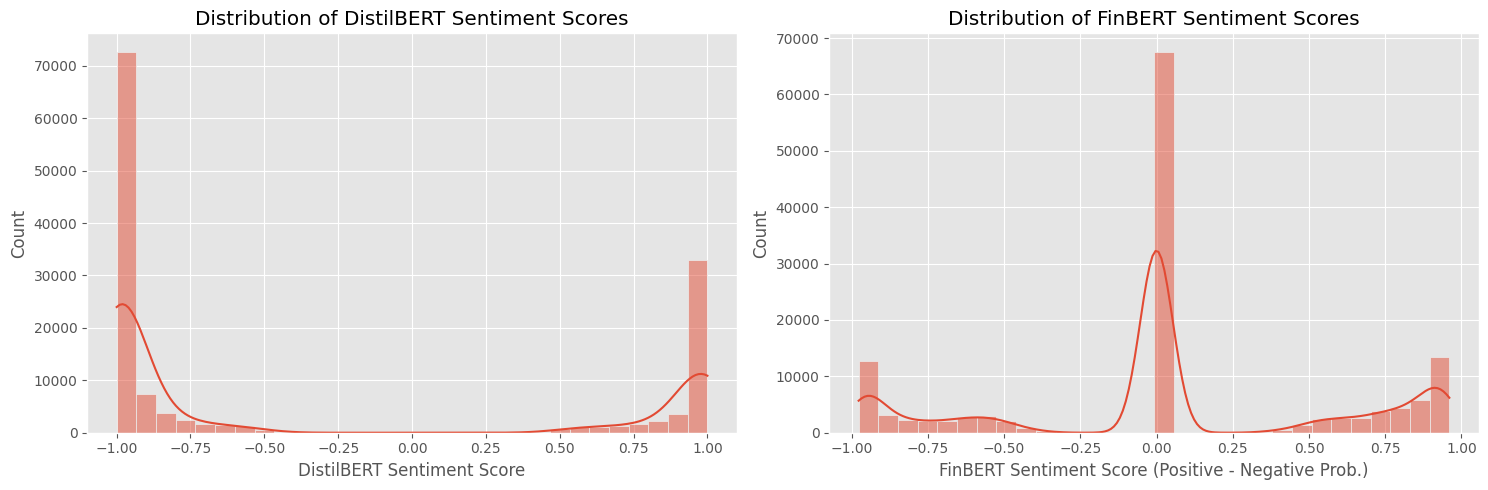


DistilBERT Sentiment Score Description:
count    135904.000000
mean         -0.331712
std           0.887511
min          -0.999814
25%          -0.994914
50%          -0.954182
75%           0.919308
max           0.999880
Name: distilbert_sentiment_score, dtype: float64

FinBERT Sentiment Score Description:
count    135904.000000
mean          0.035932
std           0.572273
min          -0.977364
25%           0.000000
50%           0.000000
75%           0.539343
max           0.960668
Name: finbert_sentiment_score, dtype: float64


In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
if 'distilbert_sentiment_score' in df.columns and df['distilbert_sentiment_score'].nunique() > 1:
    sns.histplot(df['distilbert_sentiment_score'], bins=30, kde=True, ax=axes[0])
    axes[0].set_title('Distribution of DistilBERT Sentiment Scores')
    axes[0].set_xlabel('DistilBERT Sentiment Score')
else:
    axes[0].set_title('DistilBERT Sentiment Scores not available or uniform')

if 'finbert_sentiment_score' in df.columns and df['finbert_sentiment_score'].nunique() > 1:
    sns.histplot(df['finbert_sentiment_score'], bins=30, kde=True, ax=axes[1])
    axes[1].set_title('Distribution of FinBERT Sentiment Scores')
    axes[1].set_xlabel('FinBERT Sentiment Score (Positive - Negative Prob.)')
else:
    axes[1].set_title('FinBERT Sentiment Scores not available or uniform')

plt.tight_layout()
plt.show()

if 'distilbert_sentiment_score' in df.columns:
    print("\nDistilBERT Sentiment Score Description:")
    print(df['distilbert_sentiment_score'].describe())
if 'finbert_sentiment_score' in df.columns:
    print("\nFinBERT Sentiment Score Description:")
    print(df['finbert_sentiment_score'].describe())

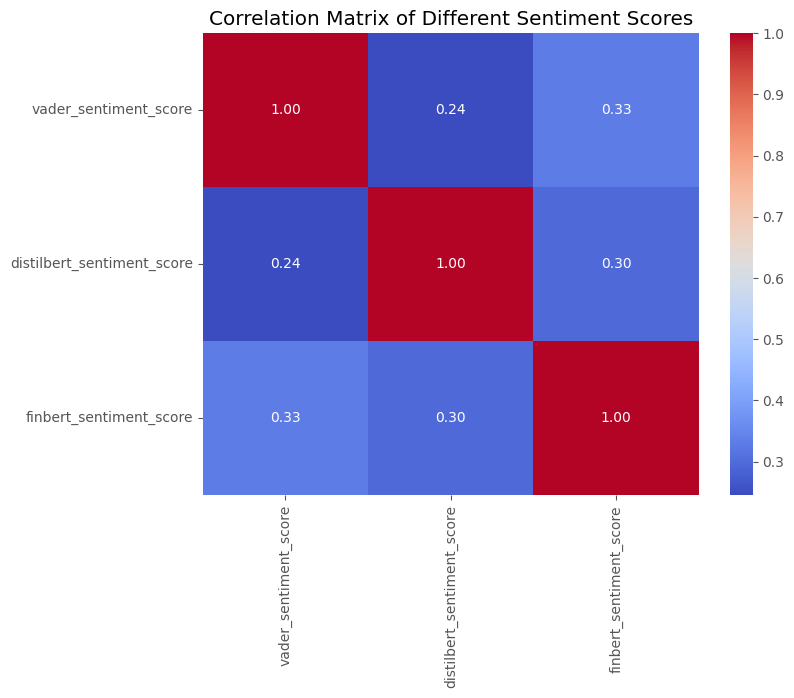

                            vader_sentiment_score  distilbert_sentiment_score  \
vader_sentiment_score                    1.000000                    0.244812   
distilbert_sentiment_score               0.244812                    1.000000   
finbert_sentiment_score                  0.329821                    0.295307   

                            finbert_sentiment_score  
vader_sentiment_score                      0.329821  
distilbert_sentiment_score                 0.295307  
finbert_sentiment_score                    1.000000  


In [28]:
sentiment_cols = ['vader_sentiment_score', 'distilbert_sentiment_score', 'finbert_sentiment_score']
# Filter out columns that might not have been created if pipelines failed
existing_sentiment_cols = [col for col in sentiment_cols if col in df.columns and df[col].nunique() > 1]

if len(existing_sentiment_cols) > 1:
    sentiment_corr = df[existing_sentiment_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(sentiment_corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Different Sentiment Scores')
    plt.show()
    print(sentiment_corr)
else:
    print("Not enough sentiment scores available for comparison.")

## 4. Time Series Analysis: Stock Price and Sentiment for a Single Ticker

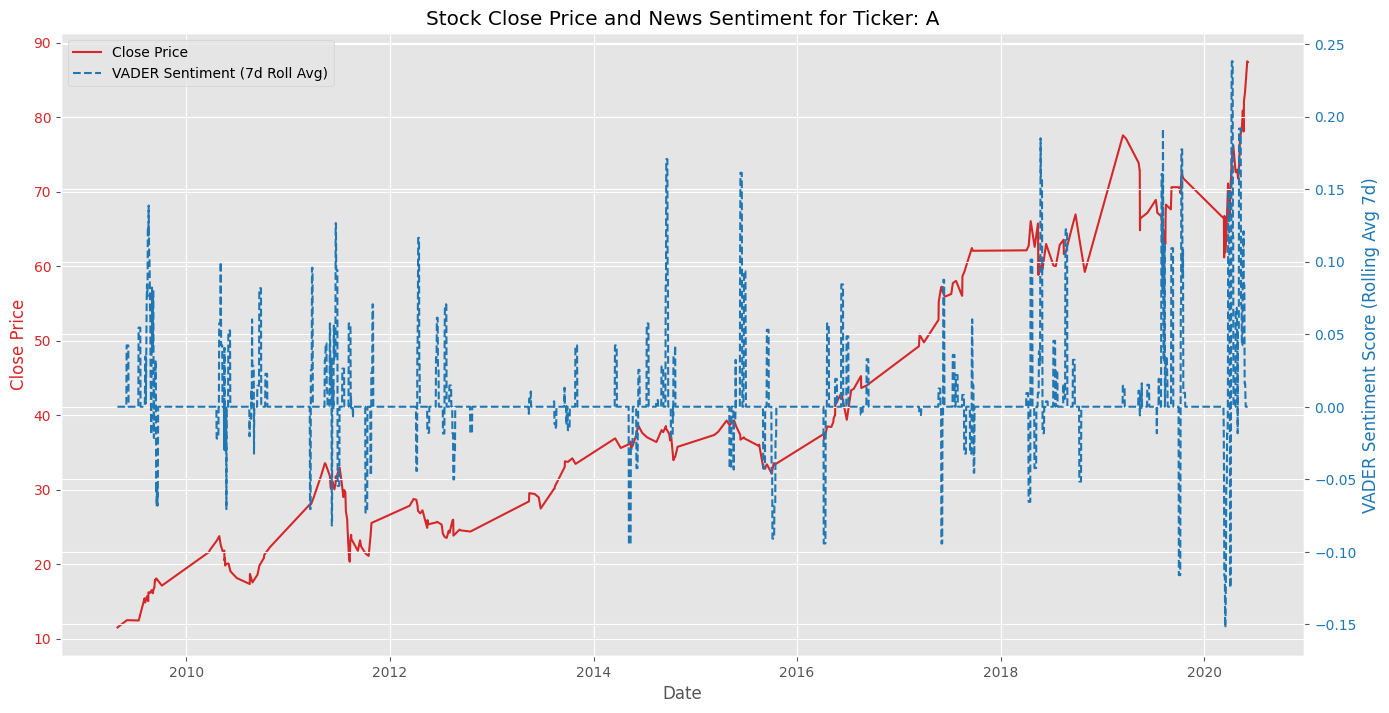

In [31]:
# Convert 'date' and 'merge_date_utc' to datetime objects
df['date'] = pd.to_datetime(df['date'], errors='coerce') # Coerce will turn unparseable dates into NaT
df['merge_date_utc'] = pd.to_datetime(df['merge_date_utc'], errors='coerce')

# Drop rows where date conversion failed, if any
df.dropna(subset=['date', 'merge_date_utc'], inplace=True)

ticker_symbol = 'A'
ticker_df = df[df['Ticker'] == ticker_symbol].copy()
ticker_df.sort_values('date', inplace=True)

if not ticker_df.empty:
    fig, ax1 = plt.subplots(figsize=(14, 7))

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color=color)
    ax1.plot(ticker_df['date'], ticker_df['Close'], color=color, label='Close Price')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('VADER Sentiment Score (Rolling Avg 7d)', color=color)  # we already handled the x-label with ax1
    # Ensure the index is a DatetimeIndex for resampling:
    if 'vader_sentiment_score' in ticker_df.columns:
        daily_vader_sentiment = ticker_df.set_index(pd.to_datetime(ticker_df['date']))['vader_sentiment_score'].resample('D').mean().fillna(0)
        ax2.plot(daily_vader_sentiment.index, daily_vader_sentiment.rolling(window=7, min_periods=1).mean(), color=color, linestyle='--', label='VADER Sentiment (7d Roll Avg)')
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Stock Close Price and News Sentiment for Ticker: {ticker_symbol}')
    # Adding legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    plt.show()
else:
    print(f"No data found for ticker {ticker_symbol}")

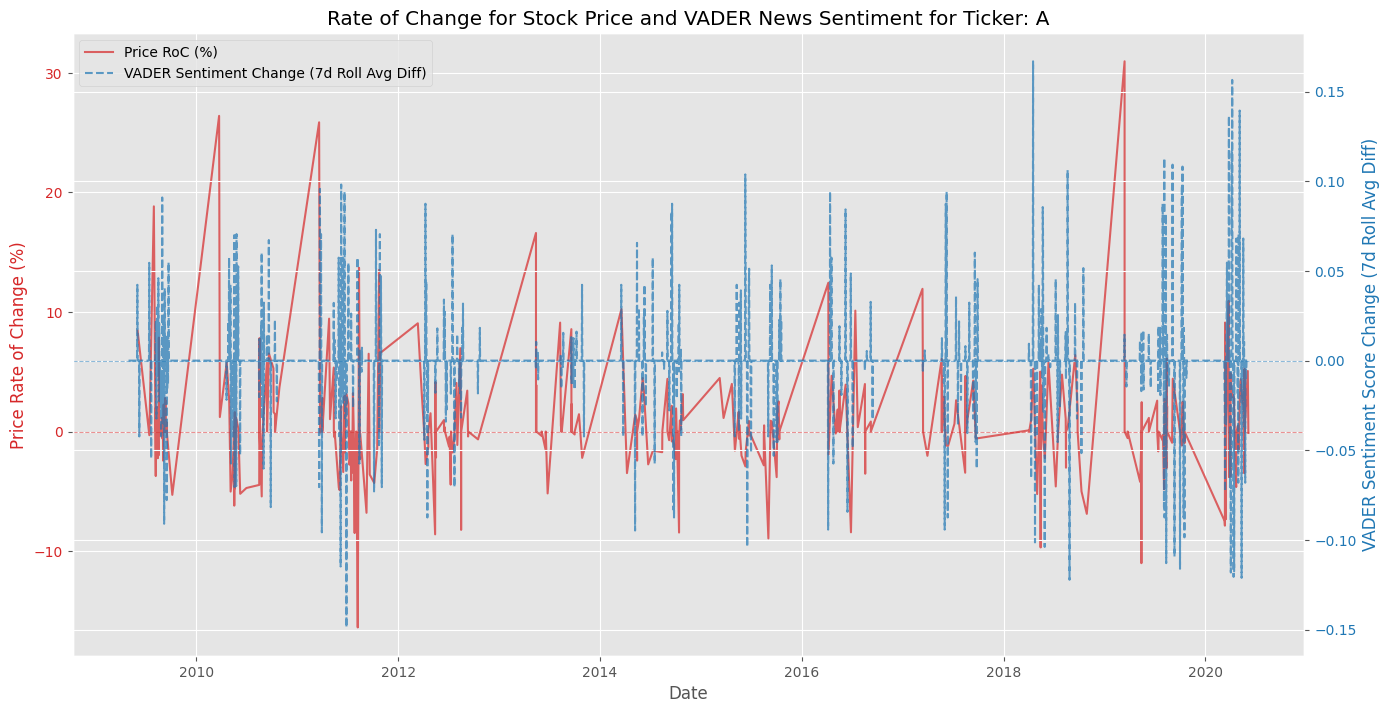

In [32]:
if not ticker_df.empty and 'vader_sentiment_score' in ticker_df.columns:
    # Calculate daily percentage change for Close price
    price_data_for_roc = ticker_df.set_index('date')['Close']
    price_roc = price_data_for_roc.pct_change() * 100  # Multiply by 100 for percentage

    # Use the existing daily_vader_sentiment (mean sentiment per day)
    sentiment_rolling_avg = daily_vader_sentiment.rolling(window=7, min_periods=1).mean()
    sentiment_roc = sentiment_rolling_avg.diff() # Simple difference

    fig, ax1_roc = plt.subplots(figsize=(14, 7))

    color = 'tab:red'
    ax1_roc.set_xlabel('Date')
    ax1_roc.set_ylabel('Price Rate of Change (%)', color=color)
    ax1_roc.plot(price_roc.index, price_roc, color=color, label='Price RoC (%)', alpha=0.7)
    ax1_roc.tick_params(axis='y', labelcolor=color)
    ax1_roc.axhline(0, color=color, linestyle='--', linewidth=0.8, alpha=0.5)

    ax2_roc = ax1_roc.twinx()
    color = 'tab:blue'
    ax2_roc.set_ylabel('VADER Sentiment Score Change (7d Roll Avg Diff)', color=color)
    ax2_roc.plot(sentiment_roc.index, sentiment_roc, color=color, linestyle='--', label='VADER Sentiment Change (7d Roll Avg Diff)', alpha=0.7)
    ax2_roc.tick_params(axis='y', labelcolor=color)
    ax2_roc.axhline(0, color=color, linestyle='--', linewidth=0.8, alpha=0.5)

    fig.tight_layout()
    plt.title(f'Rate of Change for Stock Price and VADER News Sentiment for Ticker: {ticker_symbol}')
    
    lines_roc, labels_roc = ax1_roc.get_legend_handles_labels()
    lines2_roc, labels2_roc = ax2_roc.get_legend_handles_labels()
    ax2_roc.legend(lines_roc + lines2_roc, labels_roc + labels2_roc, loc='upper left')
    
    plt.show()
else:
    print(f"No data found for ticker {ticker_symbol} or VADER sentiment to plot rate of change.")

## 5. Correlation Analysis

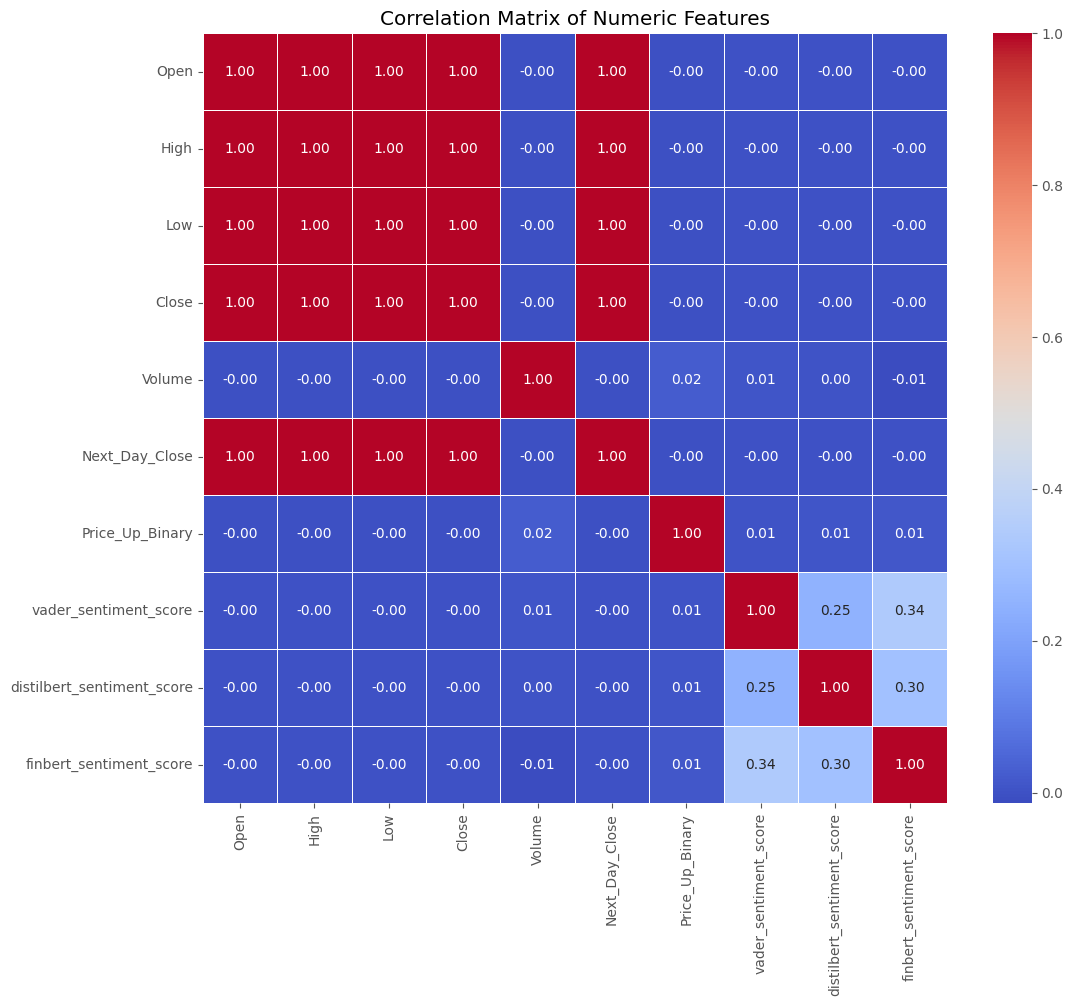

Correlation with Price_Up_Binary:
Price_Up_Binary               1.000000
Volume                        0.024515
finbert_sentiment_score       0.013330
distilbert_sentiment_score    0.008162
vader_sentiment_score         0.005511
Next_Day_Close               -0.002854
Low                          -0.003469
Close                        -0.003567
Open                         -0.003589
High                         -0.003620
Name: Price_Up_Binary, dtype: float64


In [33]:
numeric_cols_candidates = df.select_dtypes(include=np.number).columns.tolist()
# Ensure sentiment columns exist and have more than one unique value before including
numeric_cols = []
for col in numeric_cols_candidates:
    if col in df.columns and df[col].nunique() > 1:
        numeric_cols.append(col)
    elif col not in ['distilbert_sentiment_score', 'finbert_sentiment_score'] and col in df.columns: # keep other numeric cols
        numeric_cols.append(col)

if len(numeric_cols) > 1:
    correlation_matrix = df[numeric_cols].corr()
    plt.figure(figsize=(12, 10)) # Increased size for more columns
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numeric Features')
    plt.show()

    if 'Price_Up_Binary' in correlation_matrix.columns:
        print("Correlation with Price_Up_Binary:")
        print(correlation_matrix['Price_Up_Binary'].sort_values(ascending=False))
    else:
        print("'Price_Up_Binary' not found in correlation matrix.")
else:
    print("Not enough numeric columns with varied data for correlation matrix.")

## 5.1 Lag Analysis: Sentiment and Future Price Movements

We investigate if past sentiment scores (lagged sentiment) have a correlation with future price movements (specifically, the `Price_Up_Binary` target variable, which indicates if the price went up the next day).

We will calculate the daily average sentiment for each ticker and then create lagged versions of these sentiment scores. Then, we'll correlate these lagged scores with the `Price_Up_Binary` for the corresponding day.


Calculating lagged correlations for vader_sentiment_score on ticker A...
1    0.010690
2    0.029564
3    0.065607
4   -0.009631
5    0.076289
dtype: float64

Calculating lagged correlations for distilbert_sentiment_score on ticker A...
1    0.077926
2    0.005676
3    0.037989
4    0.002391
5   -0.023606
dtype: float64

Calculating lagged correlations for finbert_sentiment_score on ticker A...
1   -0.019505
2    0.058641
3    0.048183
4   -0.004219
5   -0.026396
dtype: float64


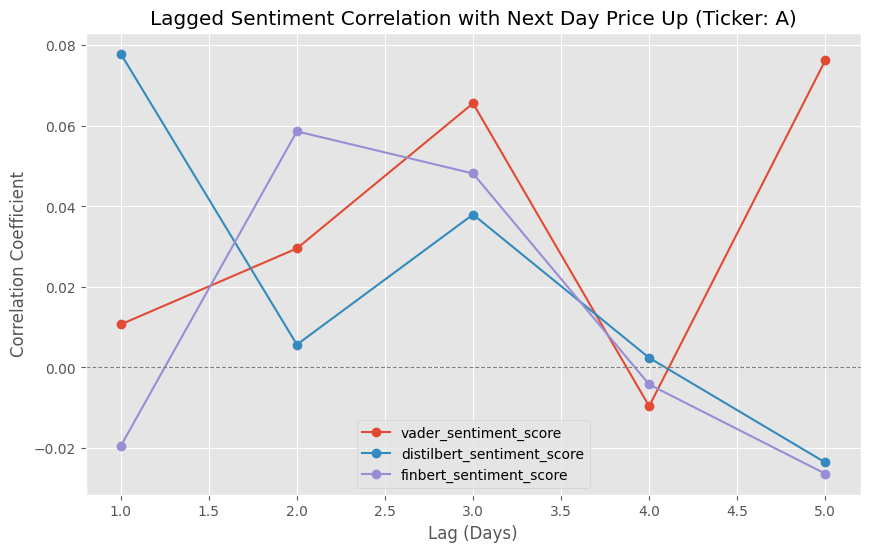

In [34]:
def calculate_lagged_correlations(df_full, ticker_symbol, sentiment_col_name, target_col='Price_Up_Binary', max_lag=5):
    if sentiment_col_name not in df_full.columns or df_full[sentiment_col_name].nunique() <= 1:
        print(f"Sentiment column {sentiment_col_name} not available or has no variance for ticker {ticker_symbol}.")
        return None
    
    ticker_data = df_full[df_full['Ticker'] == ticker_symbol].copy()
    if ticker_data.empty:
        print(f"No data for ticker {ticker_symbol}")
        return None
    
    ticker_data['date_only'] = pd.to_datetime(ticker_data['date']).dt.date
    
    # Aggregate sentiment and target per day. Use mean for sentiment, and first for binary target (assuming it's consistent for the day)
    daily_data = ticker_data.groupby('date_only').agg(
        sentiment=(sentiment_col_name, 'mean'),
        target=(target_col, 'first') # Assumes Price_Up_Binary is for the next day based on current day's close
    ).reset_index()
    daily_data.sort_values('date_only', inplace=True)
    daily_data.set_index('date_only', inplace=True)

    correlations = {}
    for lag in range(1, max_lag + 1):
        # Sentiment from 'lag' days ago
        lagged_sentiment_col = f'{sentiment_col_name}_lag_{lag}'
        daily_data[lagged_sentiment_col] = daily_data['sentiment'].shift(lag)
        
        # Correlate lagged sentiment with current day's target (Price_Up_Binary for t)
        # Price_Up_Binary already represents future price movement relative to the 'date' of the news
        corr_df = daily_data[[lagged_sentiment_col, 'target']].dropna()
        if not corr_df.empty and corr_df.shape[0] > 1 and corr_df[lagged_sentiment_col].nunique() > 1 and corr_df['target'].nunique() > 1:
            correlations[lag] = corr_df[lagged_sentiment_col].corr(corr_df['target'])
        else:
            correlations[lag] = np.nan
            
    return pd.Series(correlations)

ticker_to_analyze = 'A'
lag_results = {}
sentiment_types_for_lag = [col for col in ['vader_sentiment_score', 'distilbert_sentiment_score', 'finbert_sentiment_score'] if col in df.columns]

for sent_type in sentiment_types_for_lag:
    print(f"\nCalculating lagged correlations for {sent_type} on ticker {ticker_to_analyze}...")
    lag_corr = calculate_lagged_correlations(df, ticker_to_analyze, sent_type)
    if lag_corr is not None:
        lag_results[sent_type] = lag_corr
        print(lag_corr)

if lag_results:
    lag_results_df = pd.DataFrame(lag_results)
    plt.figure(figsize=(10, 6))
    for sent_type in lag_results_df.columns:
        plt.plot(lag_results_df.index, lag_results_df[sent_type], marker='o', label=sent_type)
    plt.title(f'Lagged Sentiment Correlation with Next Day Price Up (Ticker: {ticker_to_analyze})')
    plt.xlabel('Lag (Days)')
    plt.ylabel('Correlation Coefficient')
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"No lag analysis results to plot for ticker {ticker_to_analyze}.")

## 6. Additional Plots

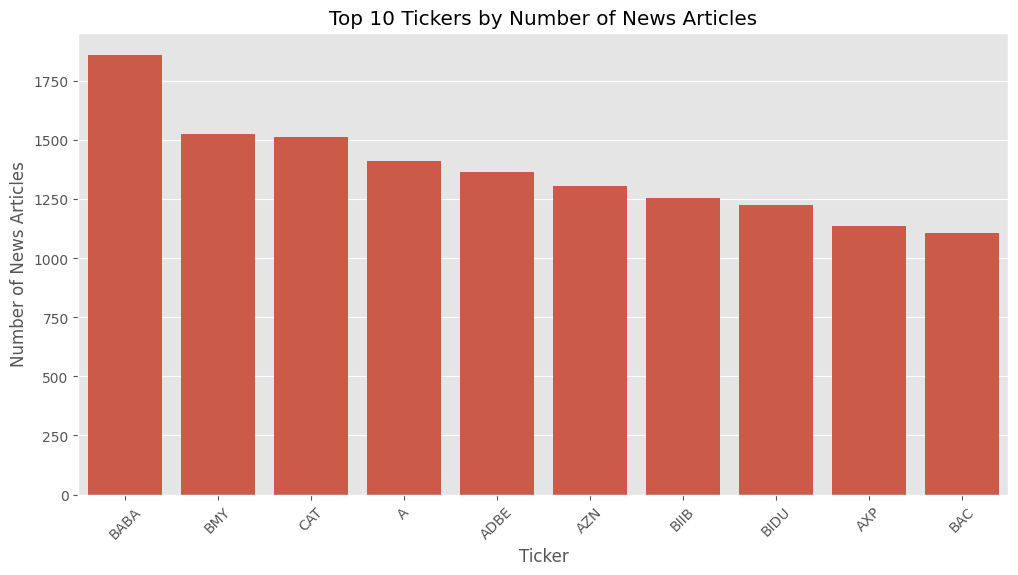

In [35]:
# Number of news articles per ticker (Top 10)
top_tickers_news_count = df['Ticker'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_tickers_news_count.index, y=top_tickers_news_count.values)
plt.title('Top 10 Tickers by Number of News Articles')
plt.xlabel('Ticker')
plt.ylabel('Number of News Articles')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_145743/385958404.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_vader_sentiment_per_ticker.index, y=avg_vader_sentiment_per_ticker.values, palette='viridis')


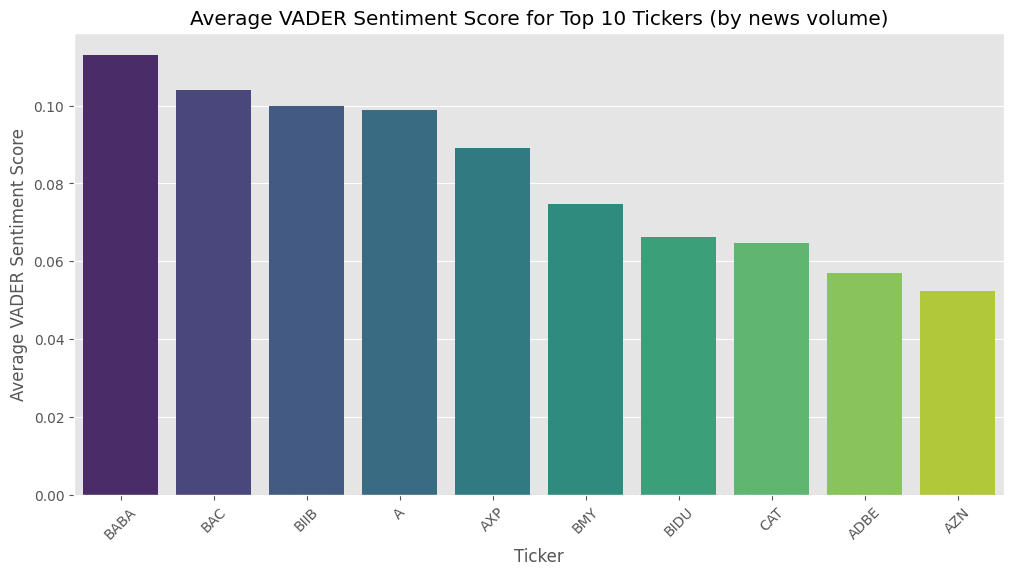

In [36]:
# Average VADER sentiment score per ticker (Top 10 by count, then show their average sentiment)
if 'vader_sentiment_score' in df.columns and df['vader_sentiment_score'].nunique() > 1:
    avg_vader_sentiment_per_ticker = df.groupby('Ticker')['vader_sentiment_score'].mean().loc[top_tickers_news_count.index].sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_vader_sentiment_per_ticker.index, y=avg_vader_sentiment_per_ticker.values, palette='viridis')
    plt.title('Average VADER Sentiment Score for Top 10 Tickers (by news volume)')
    plt.xlabel('Ticker')
    plt.ylabel('Average VADER Sentiment Score')
    plt.xticks(rotation=45)
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--') # Zero sentiment line
    plt.show()
else:
    print("VADER sentiment scores not available or uniform for plotting average sentiment per ticker.")

## 7. Conclusion

This EDA provides insights into the dataset's structure, distributions, and potential relationships between news sentiment and stock price movements.

Key observations:
* The target variable `Price_Up_Binary` shows a slight imbalance.
* VADER sentiment scores derived from news titles show a distribution centered slightly above zero. DistilBERT and FinBERT provide alternative sentiment measures, with FinBERT potentially capturing financial nuances better. Their distributions and correlations with VADER vary.
* For ticker 'A', visual inspection of VADER sentiment suggests some periods where sentiment shifts might precede or coincide with price movements, but this is not consistently clear.
* The correlation matrix shows that sentiment scores (VADER, DistilBERT, FinBERT) generally have weak correlations with `Price_Up_Binary`. The strength and direction can vary between sentiment methods.
* Lag analysis for ticker 'A' explored if past sentiment predicts next-day price direction. The results typically show weak and inconsistent correlations across different lags and sentiment types, suggesting that simple lagged sentiment may not be a strong standalone predictor for this specific setup.

Further steps could include:
* More advanced feature engineering, combining sentiment with other financial indicators and technical analysis features.
* Exploring different lag structures and target variables (e.g., magnitude of price change, volatility).
* Applying more sophisticated time-series models or machine learning models that can capture complex non-linear relationships.
* Analyzing sentiment from news content/body if available, not just titles.
* Expanding lag analysis to more tickers or an aggregated level, being mindful of computational costs.
* Building predictive models incorporating these diverse sentiment features.